In [1]:
import sys
!{sys.executable} --version

import os
import math
from math import log
# import pickle
import numpy as np
from hurst import compute_Hc
from arch import arch_model
from IPython.display import display
import matplotlib.pyplot as plt

import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
from IPython.display import display

%matplotlib inline

# import function libraries for calculating value at risk and computing backtesting statistics

from quantile_functions import *
from VaR_backtest_tests import *

# prices = pickle.load(open('stock_prices.pkl','rb'))

# # convert from prices to returns
# returns = dict()
# for k in list(prices.keys()):
#     returns[k] = get_stock_log_returns(prices[k])

Python 3.7.4


C:\Users\Elliot\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# download price history

In [2]:
# https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
# two most recently added stocks to the Dow Jones index and are listed on the NYSE
# companies, tickers = ['Facebook','Gamestop'],['FB','GME']
companies, tickers = ['Gamestop'],['GME']

tickers_df = yf.download(tickers, 
                      start='2015-01-01', 
                      end='2021-09-04', 
                      progress=False, auto_adjust=True)
display(tickers_df.head())
display(tickers_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,25.349344,25.423769,24.746496,25.155836,1612700
2015-01-05,24.947444,25.959632,24.806037,25.840551,4934900
2015-01-06,26.175459,26.815519,24.947439,25.073961,4885100
2015-01-07,25.520517,25.810776,24.545541,24.783703,2558300
2015-01-08,25.006978,25.431203,24.798588,25.073961,4547400


,Open,High,Low,Close,Volume
Date,,,,,
2021-08-30,205.000000,218.190002,203.020004,209.199997,3309600
2021-08-31,212.699997,222.300003,211.460007,218.240005,3574700
2021-09-01,224.000000,231.440002,208.020004,212.970001,4453800
2021-09-02,213.860001,214.800003,206.300003,213.520004,1852000
2021-09-03,212.050003,216.270004,198.839996,202.750000,2658600


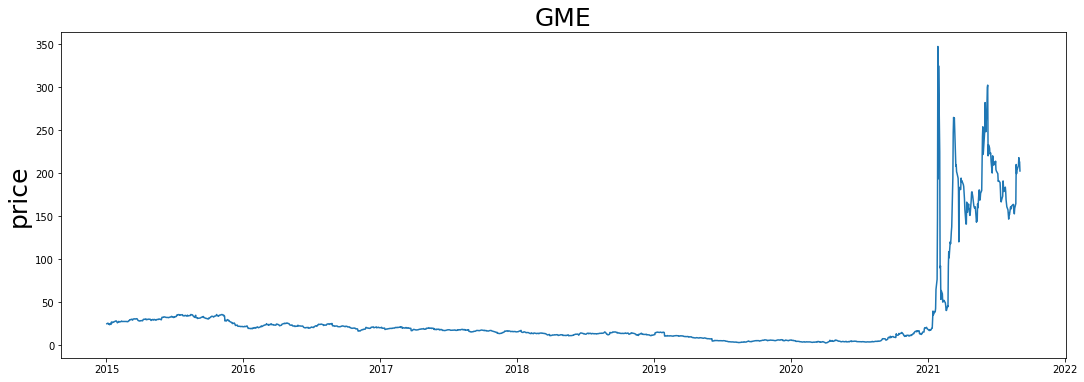

In [3]:
ticker = tickers[0]
prices = {ticker: tickers_df['Close']}

plt.figure(figsize=(18,6))
plt.plot(prices[ticker])
plt.title(ticker, fontsize=25)
plt.ylabel('price', fontsize=25)             
plt.show()

# plot daily returns

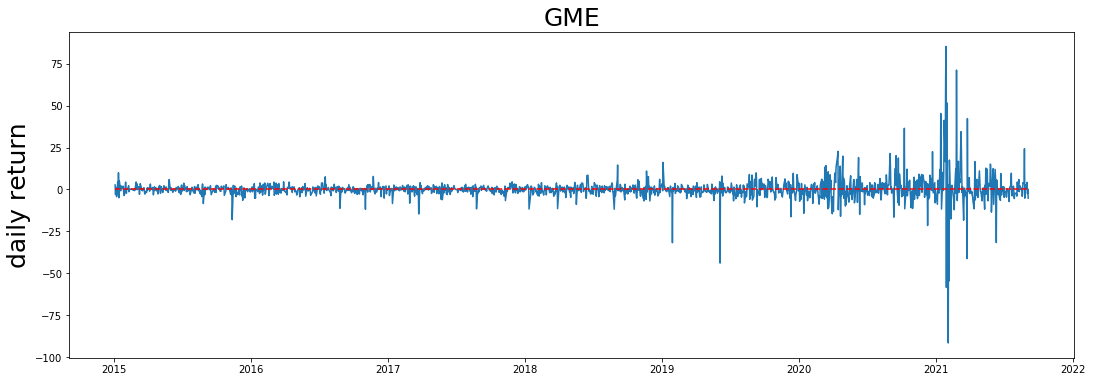

In [4]:
returns = {ticker: tickers_df['Close'].apply(log).diff()[1:]}
# returns = {ticker: tickers_df['Close'].apply(np.log).diff()[1:]}
train = returns[ticker] * 100
train2 = train * train

plt.figure(figsize=(18,6))
plt.plot(train)
plt.title(ticker, fontsize=25)
plt.plot([train.index[0], train.index[-1]], [0,0], '--',color='red')
plt.ylabel('daily return', fontsize=25) 
plt.show()

# Historical distribution of returns

In [5]:
p = 0.05

nonparametric 95.0% Value at Risk = -5.9574


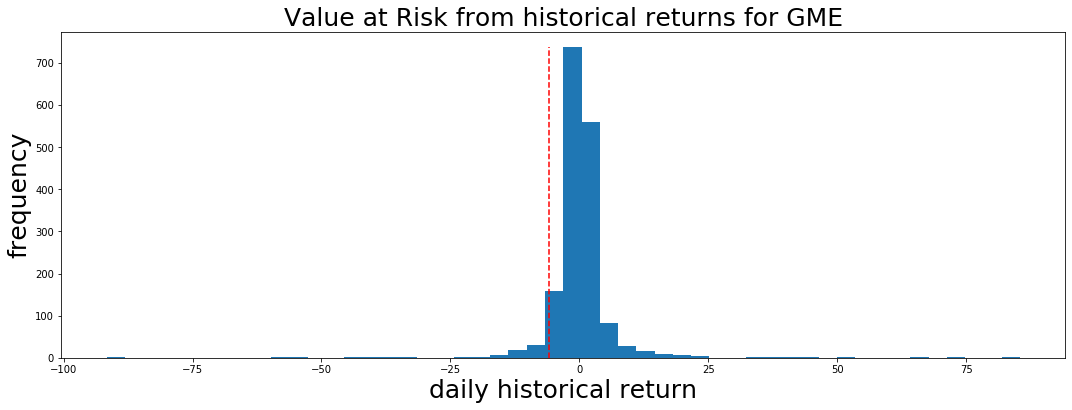

In [6]:
plt.figure(figsize=(18,6))
hist = plt.hist(train,50)
plt.title(f'Value at Risk from historical returns for {ticker}', fontsize=25)
plt.xlabel('daily historical return', fontsize=25)
plt.ylabel('frequency', fontsize=25)

VaRcutoff = np.quantile(train, p)
print(f"nonparametric {100 - 100 * p}% Value at Risk = {VaRcutoff:0.4f}")
plt.plot([VaRcutoff,VaRcutoff],[0, max(hist[0])], '--',color='red')

plt.show()

# VaR assuming a Gaussian distribution

daily return mean = 0.124219 and standard deviation = 6.825612

cutoff = -1.6449 * 6.8256 at probability 0.05

parametric 95.0% Value at Risk = -11.2271


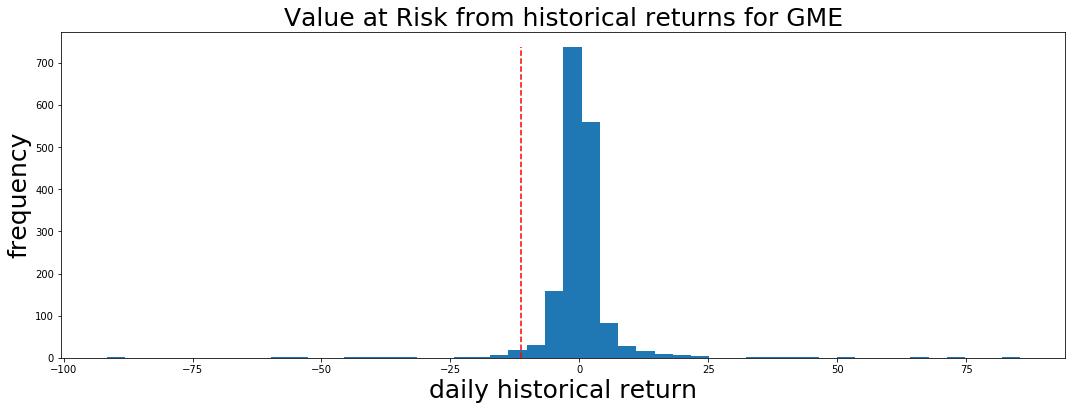

In [7]:
from scipy.stats import norm

mu, sigma = np.mean(train), np.std(train)
print(f"daily return mean = {mu:0.6f} and standard deviation = {sigma:0.6f}")

plt.figure(figsize=(18,6))
hist = plt.hist(train,50)
plt.title(f'Value at Risk from historical returns for {ticker}', fontsize=25)
plt.xlabel('daily historical return', fontsize=25)
plt.ylabel('frequency', fontsize=25)

VaRcutoff = norm.ppf(p) * sigma
print(f"\ncutoff = {norm.ppf(p):0.4f} * {sigma:0.4f} at probability {p}")
print(f"\nparametric {100 - 100 * p}% Value at Risk = {VaRcutoff:0.4f}")
plt.plot([VaRcutoff,VaRcutoff],[0, max(hist[0])], '--',color='red')

plt.show()

# MA: Fit interval moving average value at risk
## note abrupt drop and rise in VaR in late 2018

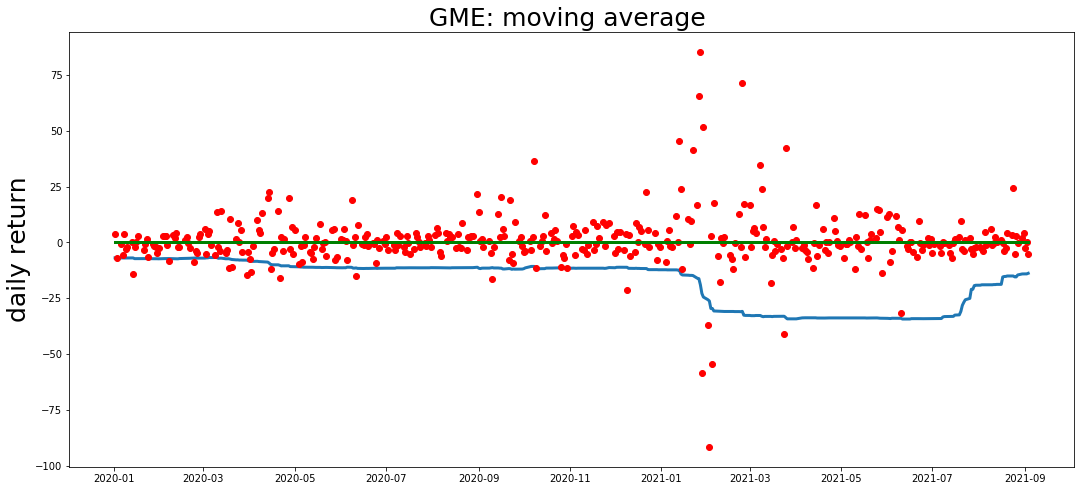

In [36]:
history_n = 120  # length of window for calculating historical volatility
MAVaR = [-1.64 * np.sqrt(np.mean(train2[i:i+history_n])) for i,_ in enumerate(train2[:-history_n])]

MAVaR_df = pd.DataFrame(MAVaR[:], index=pd.DataFrame(train).index[history_n:], columns=['VaR'])
plt.figure(figsize=(18,8))
start_date = '2020-01-01'
plt.plot(MAVaR_df[start_date:]['VaR'],linewidth=3)
plt.plot(pd.DataFrame(train[start_date:]), 'ro')
plt.plot(pd.DataFrame([0,0],index=MAVaR_df[start_date:].index[[0,-1]]), 'g-',linewidth=3)
plt.title(ticker + ": moving average ", fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

### MA goodness of fit

#### Kupiec unconditional likelihood ratio test (LRuc): the calculations

In [22]:
returns_0, Value_at_Risk, p = train[start_date:], MAVaR_df[start_date:]['VaR'], p
e = returns_0 < Value_at_Risk  
N, x = len(e),sum(e)

print(f"N = {N}, exceptions = {x}, target probability = {p}\n")

LRuc = -2 * np.log(pow(p, x) * pow(1 - p, N - x) / (pow(x / N, x) * pow(1 - x / N, N - x)))
print({"LRuc": LRuc, "pvalue": chi2(1).cdf(LRuc)})  


N = 423, exceptions = 18, target probability = 0.05

{'LRuc': 0.5189744692671552, 'pvalue': 0.5287205276821927}


#### Kupiec test results

{'LRuc': 0.5189744692671552, 'pvalue': 0.5287205276821927}

,statistic,pvalue
test,,
LRuc,0.518974,0.528721
LRind,0.070495,0.034634
LR,0.589470,0.255271
uniform distribution statistic,0.378251,0.008002
interval statistic,0.199732,0.453254


exceptions = 18 percent =  0.04255 expected =  0.05


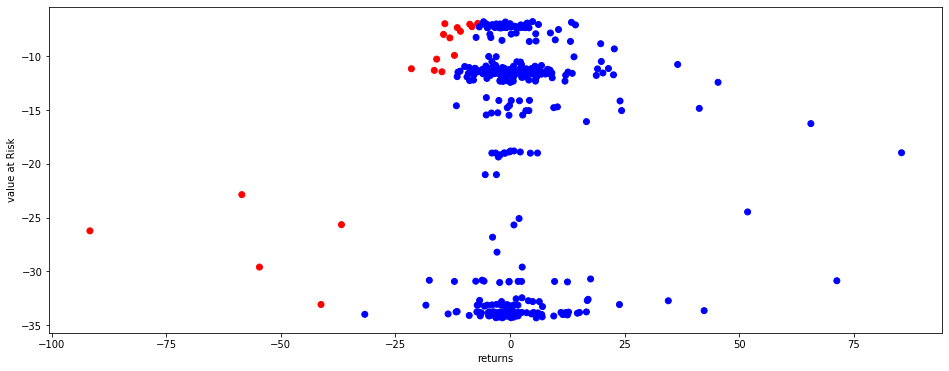

In [23]:
fitMA = VaR_goodness_of_fit(train[start_date:], MAVaR_df[start_date:]['VaR'], p)

display(fitMA.Kupiec_uc_test())

display(fitMA.all_test_results())

fitMA.print_exception_pct()
fitMA.scatterplot_returns_vs_VaR()

# EWMA: exponential weighted moving average volatiity

$$\sigma^2_n = (1 - \lambda) u^2_{n-1} + \lambda \sigma^2_{n-1}$$ 

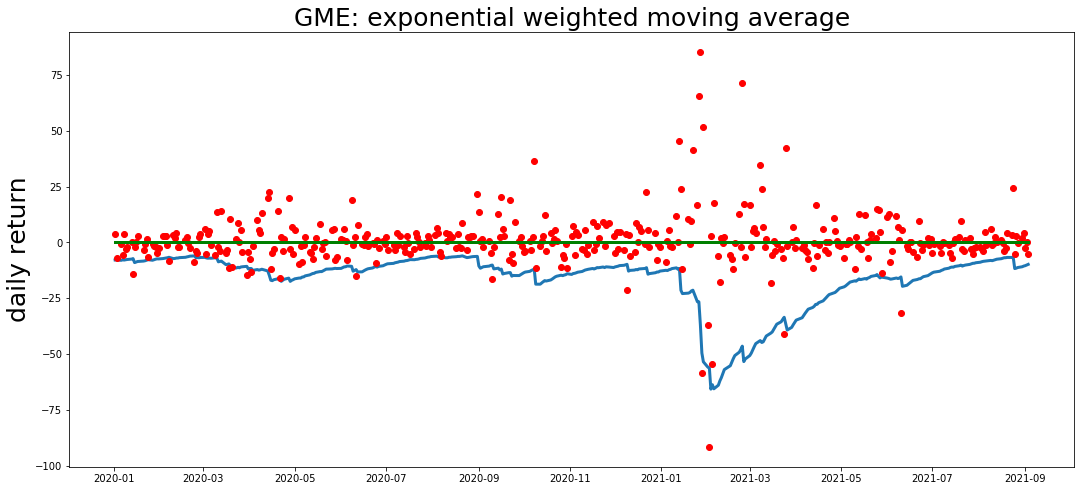

In [37]:
train2 = train * train

wt = .94
vol = train2[0]
vol_history = [0,vol]  # move everything forward one day
for v in train2[1:]:
    vol = wt * vol + (1 - wt) * v
    vol_history.append(vol)
    
vol_df = pd.DataFrame(vol_history[:-1], index=train.index, columns=['vol'])
vol_df['EWMA'] = [-1.64 * math.sqrt(x) for x in vol_df['vol']]

plt.figure(figsize=(18,8))
plt.plot(vol_df['2020-01-01':]['EWMA'], linewidth=3)
plt.plot(pd.DataFrame(train['2020-01-01':]), 'ro')
plt.plot(pd.DataFrame([0,0],index=MAVaR_df[start_date:].index[[0,-1]]), 'g-',linewidth=3)
plt.title(ticker + ': exponential weighted moving average', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

### EWMA goodness of fit

In [38]:
fitEWMA = VaR_goodness_of_fit(train['2020-01-01':], vol_df['2020-01-01':]['EWMA'], p)
fitEWMA.print_exception_pct()
display(fitEWMA.all_test_results())

exceptions = 13 percent =  0.03073 expected =  0.05


,statistic,pvalue
test,,
LRuc,3.810231,0.949060
LRind,0.826545,0.338518
LR,4.636776,0.901568
uniform distribution statistic,0.312602,0.125828
interval statistic,0.307950,0.165508


# GARCH(1,1) model

$$\sigma^2_n = \omega + \alpha u^2_{n-1} + \beta \sigma^2_{n-1}$$

In [26]:
returns

{'GME': Date
 2015-01-05    0.026855
 2015-01-06   -0.030115
 2015-01-07   -0.011644
 2015-01-08    0.011644
 2015-01-09   -0.043063
                 ...   
 2021-08-30    0.020525
 2021-08-31    0.042305
 2021-09-01   -0.024444
 2021-09-02    0.002579
 2021-09-03   -0.051757
 Name: Close, Length: 1680, dtype: float64}

GME
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1685.6951751215784
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1685.6309146363615
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1685.3890953069074
Iteration:      4,   Func. Count:     26,   Neg. LLF: 1682.9022193806038
Iteration:      5,   Func. Count:     31,   Neg. LLF: 1682.8677919864479
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1682.8495824530264
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1682.8477711279081
Iteration:      8,   Func. Count:     50,   Neg. LLF: 1682.847769971551
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1682.8476543108754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1682.8476543099412
            Iterations: 10
            Function evaluations: 57
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared: 

C:\Users\Elliot\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Elliot\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


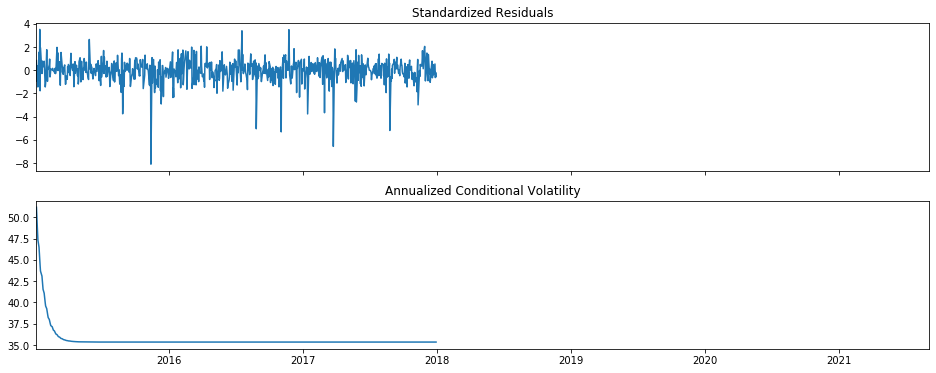

In [27]:
print(ticker)
train = returns[ticker] * 100

model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
res = model.fit(last_obs='2017-12-31')
print(res.summary())
plt.rc("figure", figsize=(16, 6))
fig = res.plot(annualize='D')
print(res.params, res.tvalues, res._params, res._names)

### GARCH parameters

In [28]:
display(pd.DataFrame(res.params))
persistence = res.params['alpha[1]'] + res.params['beta[1]']
print(f"\npersistence = {persistence:0.3} (speed of mean reversion see Jorion Fig 9-6 page 229)")
print(f"unconditional variance = {res.params['omega'] / ( 1 - persistence): 0.3}")

,params
omega,0.386937
alpha[1],0.000000
beta[1],0.921976



persistence = 0.922 (speed of mean reversion see Jorion Fig 9-6 page 229)
unconditional variance =  4.96


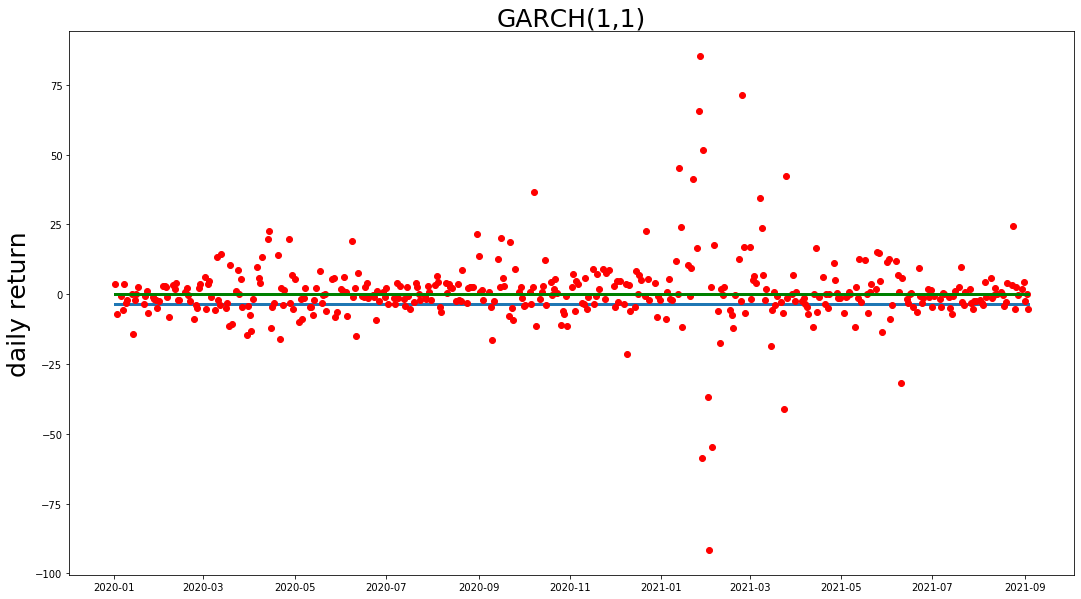

In [33]:


forecasts = res.forecast(start='2020-01-01') # .variance['h.1']
cond_mean = forecasts.mean['2020-01-01':]
cond_var = forecasts.variance['2020-01-01':]
q = model.distribution.ppf([p]) 
value_at_risk = pd.DataFrame([-x[0] for x in -cond_mean.values - np.sqrt(cond_var).values * q], 
                             index=train['2020-01-01':].index)
plt.figure(figsize=(18,10))
plt.plot(value_at_risk, linewidth=3)
plt.plot(train['2020-01-01':], 'ro')
plt.plot(pd.DataFrame([0,0],index=MAVaR_df[start_date:].index[[0,-1]]), 'g-',linewidth=3)
plt.title('GARCH(1,1)', fontsize=25)
plt.ylabel('daily return', fontsize=25)
plt.show()

### variance of variance and adjusted variance

,variance,mean,n
daily_return,8.037305e+01,0.276393,926
model_volatility,4.935711e-28,2.226923,926
adjusted_return,1.620691e+01,0.124114,926


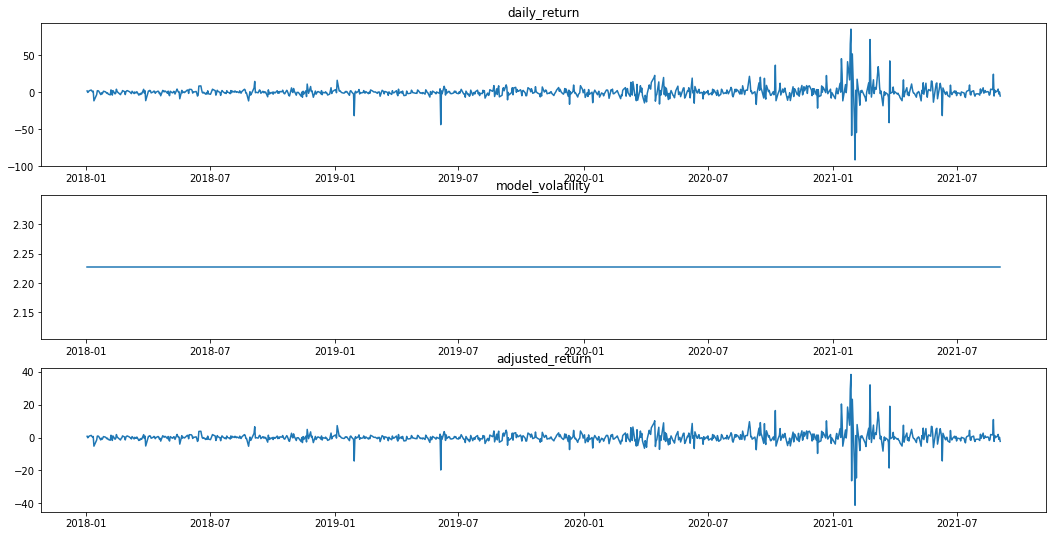

In [30]:
v = pd.DataFrame([(u, math.sqrt(s), u/math.sqrt(s)) for u,s in zip(train['2018-01-01':], res.forecast().variance['h.1']['2018-01-01':])],
                columns=['daily_return','model_volatility','adjusted_return'],
                index=train['2018-01-01':].index)

variances = pd.concat([v.var(), v.mean(), v.count()], axis=1)
variances.columns = ['variance','mean','n']
display(variances)

plt.figure(figsize=(18,9))
for i, c in enumerate(v.columns):
    plt.subplot(3,1,i+1)
    plt.title(c)
    plt.plot(v[c])
plt.show()

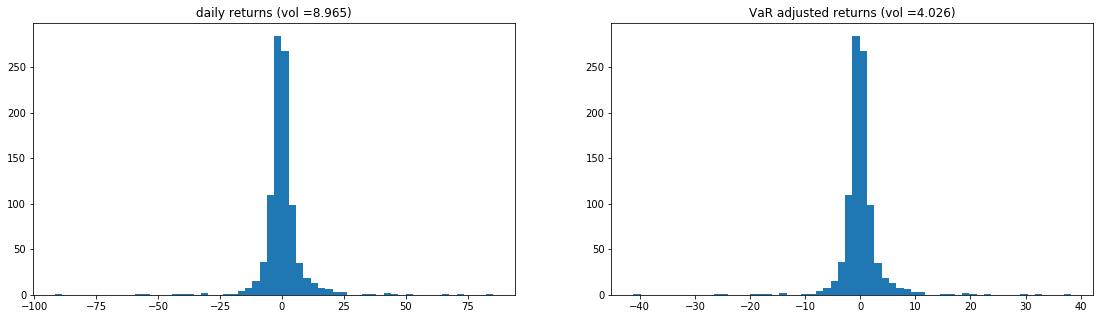

In [31]:
plt.figure(figsize=(19,5))
plt.subplot(1,2,1)
plt.hist(v['daily_return'], 60)
plt.title(f"daily returns (vol ={v['daily_return'].std():0.4})")
plt.subplot(1,2,2)
plt.hist(v['adjusted_return'], 60)
plt.title(f"VaR adjusted returns (vol ={v['adjusted_return'].std():0.4})")
plt.show()

### GARCH goodness of fit

,statistic,pvalue
test,,
LRuc,173.159477,1.000000e+00
LRind,1.161702,4.405778e-01
LR,174.321179,1.000000e+00
uniform distribution statistic,0.085598,4.303372e-01
interval statistic,0.564688,1.264968e-30


exceptions = 101 percent =  0.2388 expected =  0.05


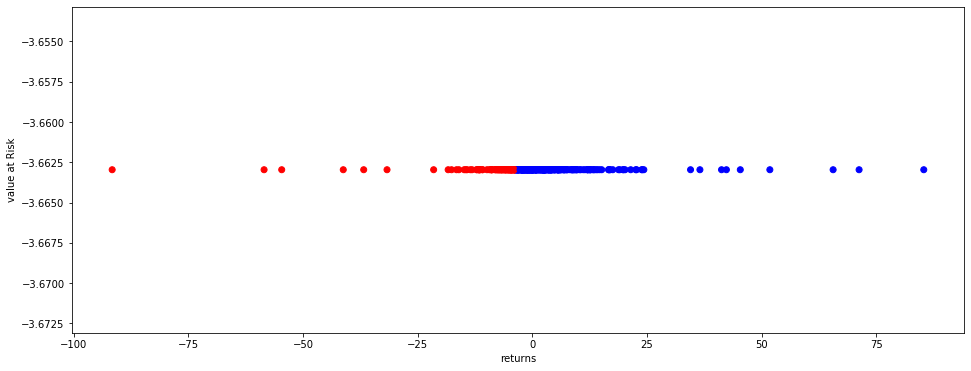

In [39]:
fit = VaR_goodness_of_fit(train['2020-01-01':], value_at_risk.iloc[:,0], p)
display(fit.all_test_results())

fit.print_exception_pct()
fit.scatterplot_returns_vs_VaR()